## Results of the first challenge and hw1 

- announcement of results
- winners' talks


**HW comments:**
* you can use markdown for long text comments
* don't redefine some variables using the same cell
* after preparing all code, restart and run all cells, to obtain consistent execution
* interpreting results of an experiment is important
* deadline is deadline, solutions are not accepted after publishing reference solution

## Problems where close approaches are used

Linear models are very good at incorporating information from lots of simple features

- opinion mining
- text categorization
- spam filtering 
- internet advertisements
- basic recommendation systems

Many enhancements to linear models are possible.

The more data — the more complex models are possible. 

# Previous time

- discussed different modification of kNN
- Simple ensembling

     - averaging works (we tried it previous time)
     - combining similar classifiers doesn't make much sense
     - weighted voting is fine in many situations


# Recall about decision trees

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from utils import plot_classifier_decision

X, y = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=23)

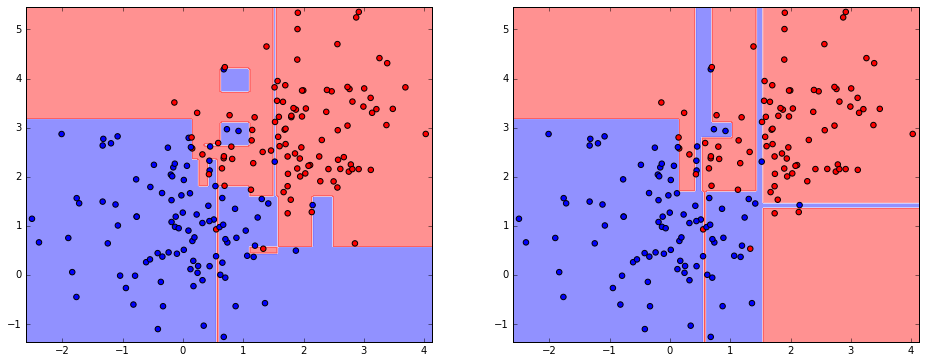

In [2]:
plt.figure(figsize=[16, 6])
plt.subplot(121)
left_tree = DecisionTreeClassifier(random_state=42).fit(X, y)
plot_classifier_decision(left_tree, X, y)
plt.subplot(122)
# same, but 20 events were removed
right_tree = DecisionTreeClassifier(random_state=42).fit(X[20:], y[20:])
plot_classifier_decision(right_tree, X[20:], y[20:])

# Ensembles and stacking

## Random Forest (2001)

Builds independently many trees. 

Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

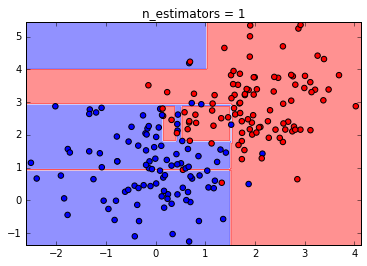

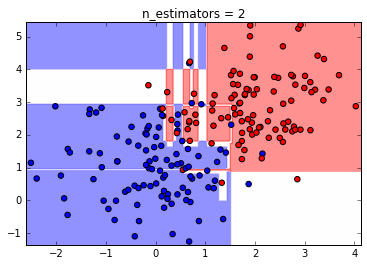

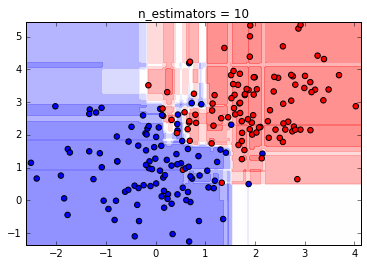

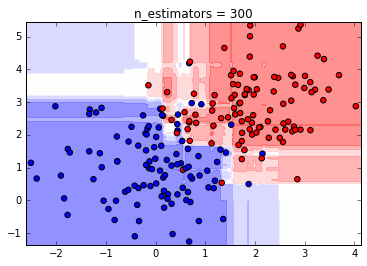

In [3]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
for n_trees in [1, 2, 10, 300]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42).fit(X, y)
    plot_classifier_decision(rf, X, y)
    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

# Overfitting 

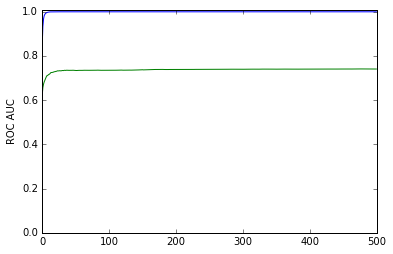

In [4]:
# defining toy datasets
toy_trainX, toy_trainY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=42, cluster_std=1.5)
toy_testX,  toy_testY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=3, cluster_std=1.5)
# train random forest
rf = RandomForestClassifier(n_estimators=500).fit(toy_trainX, toy_trainY)


# compute the ROC AUC after adding one more estimator in the ensemble
for toyX, toyY, label in [(toy_trainX, toy_trainY, 'train'), (toy_testX, toy_testY, 'test')]:
    predictions = numpy.zeros(len(toyX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(toyX)
        curve.append(roc_auc_score(toyY, predictions))
    plt.plot(curve)
    plt.ylim(0, 1.01)
    plt.ylabel('ROC AUC')

### Random Forest
- terribly simple
- has huge difference of the quality between predictions on train and validation sample
- it's quality never goes down with increasing the number of trees
- **never overfits**
    - huge difference between predictions on test and training does not imply the model is bad, RF is such model


But approach used by many physicists today (detect differenct between training and test) says 'it is overfitted' for random forest. So don't use this approach :)

<img src='http://arogozhnikov.github.io/images/etc/no_tmva_plot.gif' width='400' alt='these plots are not useful' />

## also...
- RF efficiently works with features of different scale and nature
- doesn't require tuning 
- for large datasets may produce giant trees (which is long and takes lots of memory). <br />
  Makes sense to limit growth of trees (`max_depth` or `min_samples_leaf`)
- works well in many situations.

# Random forest for wines

taking the same splitting

In [5]:
import pandas
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
data = pandas.read_csv('data/2-winequality-white.csv', sep=';')
winesY = data['quality'].values
winesX = data.drop('quality', axis=1)
trainX, testX, trainY, testY = train_test_split(winesX, winesY, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=200).fit(trainX, trainY)
mean_squared_error(testY, rf_reg.predict(testX))

0.36014742857142862

## Exercise 

- read the function below
- use it to compare the behavior of a single default DecisionTree and a RandomForest.
    - Explain the results for train error (for both models)
    - Does increasing `n_estimators` in Random Forest play any role?

In [6]:
def test_random_states(estimator):
    values_test = []
    values_train = []
    # setting random state
    estimator.set_params(random_state=42)
    for random_state in range(10):
        trainX, testX, trainY, testY = train_test_split(winesX, winesY, random_state=random_state)
        # refitting to new data would retrain the model from the scratch
        estimator.fit(trainX, trainY)
        values_test.append(mean_squared_error(testY, estimator.predict(testX)))
        values_train.append(mean_squared_error(trainY, estimator.predict(trainX)))
    print 'test error:', numpy.mean(values_test), numpy.std(values_test),
    print 'train error:', numpy.mean(values_train), numpy.std(values_train)

In [7]:
# your code

# AdaBoost (Adaptive Boosting, 1997) demonstration

AdaBoost operates by reweighting samples each time. <br />
Weight of sample is increased if base classifier makes a mistake.

Formally this corresponds to minimizing exponential loss function.
In the following demonstration we use trees of depth 1.

<!--- important note - illustration below gives the idea, but numerically incorrect -->

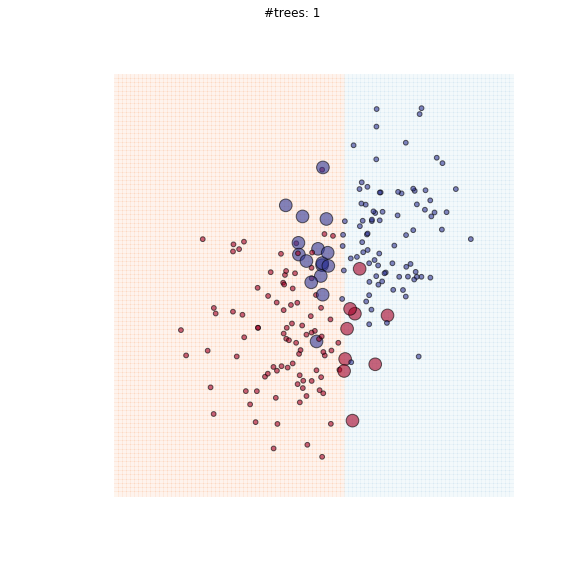

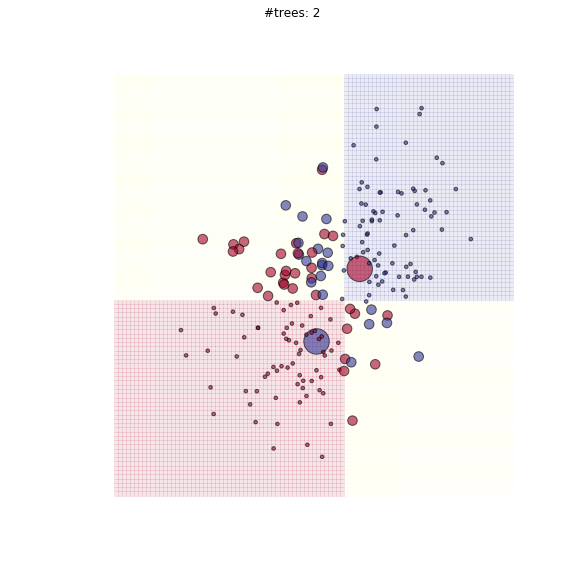

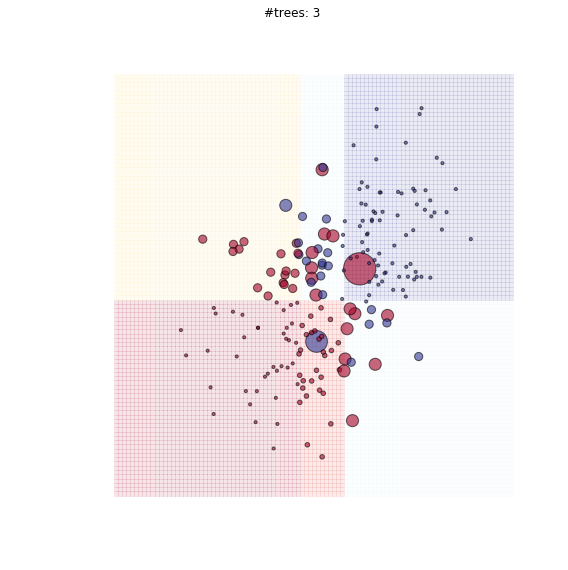

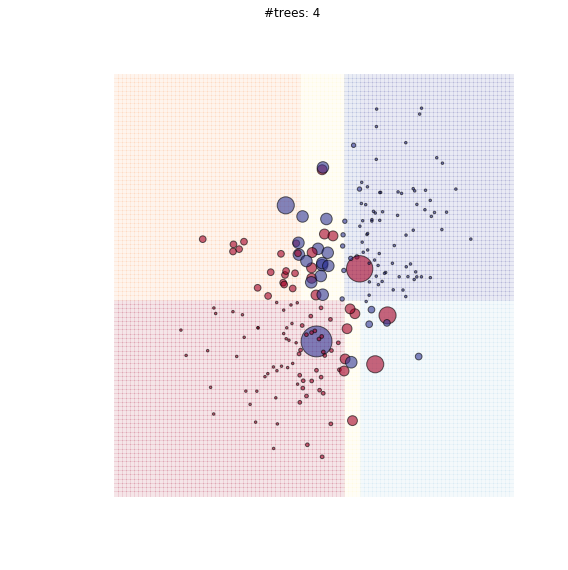

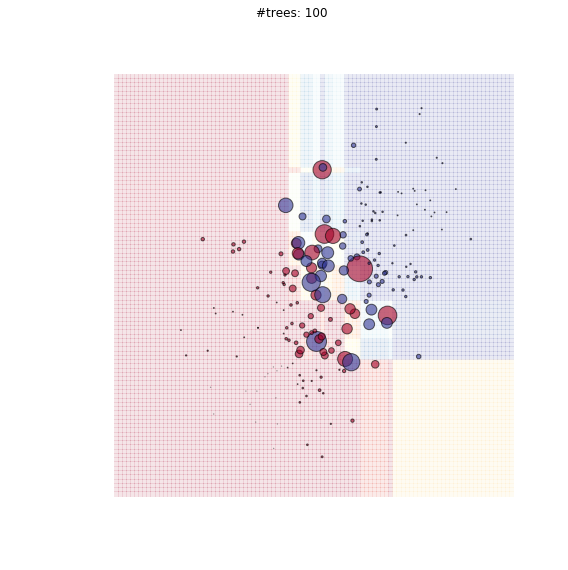

In [8]:
# Hand-made AdaBoost! It's quite simple!
xx, yy = numpy.meshgrid(numpy.linspace(-4, 5, 100), numpy.linspace(-2, 6, 100))
weights = numpy.ones(len(X))
Z = 0 * xx.flatten()
Z[0] = 0.1
Z[-1] = -0.1

for iteration in range(101):
    if iteration in [1, 2, 3, 4, 100]:
        plt.figure(figsize=[8, 8])
        plt.pcolormesh(xx, yy, Z.reshape(xx.shape),  alpha=0.1, cmap='RdYlBu', vmin=-2, vmax=2)
        plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, s=40 * weights / weights.mean(), cmap='RdYlBu')
        plt.axis('off')
        plt.title('#trees: {}'.format(iteration))
        plt.tight_layout()
    

    tree = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=weights)
    is_correct = (y == tree.predict(X))
    alpha = 0.5 * numpy.log(numpy.sum(is_correct * weights) / numpy.sum((1 - is_correct) * weights))
    weights *= numpy.exp(- alpha * (2 * is_correct - 1))
    Z = Z + alpha * (2 * tree.predict(numpy.c_[xx.ravel(), yy.ravel()]) - 1)

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
# define Ada Boost classifier over Decision Trees
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=DecisionTreeClassifier(max_depth=3))

# you can train AdaBoost over other classifiers
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=GaussianNB())

# Gradient Boosting (GB) demonstration

GBDT approximates target dependency by making steps in the space of functions:

* [GB explanation](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

# Gradient Boosting playground

* [GB playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
* play with it to understand the most important knobs and ideas of GB

AdaBoost is a particular case of Gradient Boosting.

GB = GBDT = GBRT = GBM = MART, these are names of same approach.

## Working with GB in sklearn

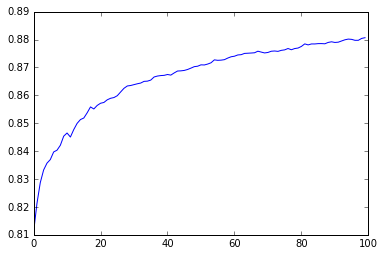

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
# define the Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
new_trainY = trainY > 6
new_testY = testY > 6
# fit the GB
gb_clf.fit(trainX, new_trainY)

# compute qualtity, ROC AUC, after adding one more estimator into the ensemble
# use for this `staged_predict_proba` - iterator over predictions on each boosting iteration
test_qualities = []
for p in gb_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(new_testY, p[:, 1]))
plt.plot(test_qualities)

# Second challenge is [flavour tagging of mesons](https://inclass.kaggle.com/c/flavour-tagging) 

The goal of this competition is to determine the flavour of charged B mesons (mesons that contain b or anti-b quark).

<img src='https://raw.githubusercontent.com/yandexdataschool/MLatImperial2017/master/img/quarks.png' width='400' alt='B mesons structure' />

To make challenge even more realistic, the data is stored in ROOT — beloved format in HEP. <br />
ROOT keeps your data fresh and healthy! (joking)

In [12]:
# use wget command to download the data. 

In [13]:
# define the function to create submission
from IPython.display import FileLink
def create_solution(predictions, filename='2-flavour-predictions.csv'):
    result = pandas.DataFrame({'ID': numpy.arange(len(predictions)), 'Prediction': predictions})
    result.to_csv('data/{}'.format(filename), index=False)
    return FileLink('data/{}'.format(filename))

In [14]:
# use root_numpy, pythonic wrapper over ROOT, to read data from the file
# convert read data into pandas
import root_numpy
# read dataset with B-meson description
dataB = pandas.DataFrame(root_numpy.root2array('./data/trainingB.root', treename='tree'))
# read dataset with all other tracks description in the collision
dataTrack = pandas.DataFrame(root_numpy.root2array('./data/trainingTrack.root', treename='tree'))

In [15]:
# read test samples with the same structure
kaggle_dataB = pandas.DataFrame(root_numpy.root2array('./data/testB.root', treename='tree'))
kaggle_dataTrack = pandas.DataFrame(root_numpy.root2array('./data/testTrack.root', treename='tree'))

<img src='https://raw.githubusercontent.com/yandexdataschool/MLatImperial2017/master/img/Bflavour.png' width='800' alt='Collision structure' />

In [16]:
dataB.head()

,ID,ptB,etaB,phiB,chargeB
0,0,2.064923,4.255869,4.096291,1
1,1,9.074567,3.839642,0.803946,-1
2,2,5.604867,3.031174,6.268456,-1
3,3,5.689791,3.920532,5.792208,1
4,4,7.166367,2.956910,2.446713,1


In [17]:
dataB.shape

(250000, 5)

In [18]:
dataTrack.head()

,ID,ptTrack,etaTrack,phiTrack,track_quality,PIDe,PIDk,PIDmu,PIDpi,PIDp,PIDghost,IP,IPerr,vertexIP,EOverP,Edx,chargeTrack
0,0,3.122201,3.719456,4.323421,1.630143,5.306696e-04,0.640957,-999,0.703629,0.000070,0.031249,9.268527,0.010537,3.450082,-999.000000,0.881765,-1
1,0,2.177951,2.121020,6.122622,1.096576,7.339656e-05,0.000198,-999,0.985658,0.001393,0.001943,0.103917,0.020943,520.172180,-999.000000,0.832958,-1
2,0,1.416451,3.147866,2.778954,1.169991,3.348872e-04,0.054081,-999,0.568771,0.188799,0.011440,0.032704,0.023889,255.362961,0.698145,0.869784,1
3,0,1.039049,1.992837,3.910394,0.643400,1.908508e-07,0.000090,-999,0.996812,0.000584,0.001059,0.018182,0.023879,324.237823,-999.000000,0.904225,-1
4,0,0.737614,3.077182,4.055139,1.252629,1.325996e-03,0.634082,-999,0.035756,0.304926,0.006668,17.069895,0.016652,7.975696,0.718094,0.916197,1


In [19]:
dataTrack.shape

(2414776, 17)

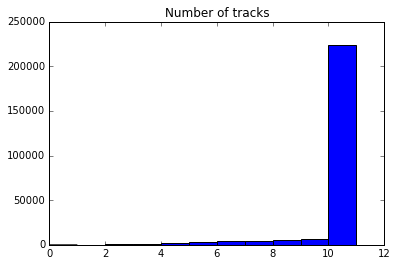

In [20]:
# plot number of tracks in each collision
_, n_tracks = numpy.unique(dataTrack.ID, return_counts=True)
plt.hist(n_tracks, bins=11, range=(0, 11))    
plt.title('Number of tracks')

In [21]:
# do cross-validation: divide indices of collisions
trainID, testID = train_test_split(dataB.ID, random_state=42, train_size=0.5)

## Tracks preprocessing: 
take only one track with the maximum transverse momentum as the most relevant track to define the flavour of B meson

In [22]:
def take_max_pt_tracks_ids(track_pts, ids):
    """
    max is computing over tracks in the same collision for the same data
    """
    # using trick from http://arogozhnikov.github.io/2015/09/30/NumpyTipsAndTricks2.html
    ids_unique, ids_enumerated = numpy.unique(ids, return_inverse=True)

    track_sorter = numpy.argsort(track_pts)
    # order of track in pt
    track_ordered = numpy.argsort(track_sorter)

    top_track = numpy.zeros(len(ids_unique), dtype=int)
    numpy.maximum.at(top_track, ids_enumerated, track_ordered)
    top_track = track_sorter[top_track]
    return top_track

In [23]:
ids_of_tracks_with_max_pt = take_max_pt_tracks_ids(dataTrack.ptTrack.values, dataTrack.ID.values) 
data_max_pt = dataTrack.ix[ids_of_tracks_with_max_pt, :]
# reindex for later usage
data_max_pt.index = numpy.arange(len(data_max_pt))
# apply to kaggle test samples also
kaggle_ids_of_tracks_with_max_pt = take_max_pt_tracks_ids(kaggle_dataTrack.ptTrack.values, kaggle_dataTrack.ID.values)
kaggle_data_max_pt = kaggle_dataTrack.ix[kaggle_ids_of_tracks_with_max_pt, :]

In [24]:
data_max_pt.head()

,ID,ptTrack,etaTrack,phiTrack,track_quality,PIDe,PIDk,PIDmu,PIDpi,PIDp,PIDghost,IP,IPerr,vertexIP,EOverP,Edx,chargeTrack
0,0,3.122201,3.719456,4.323421,1.630143,0.000531,0.640957,-999,0.703629,0.000070,0.031249,9.268527,0.010537,3.450082,-999.000000,0.881765,-1
1,1,1.637884,3.518827,3.759710,0.859436,0.000023,0.000819,-999,0.938859,0.000084,0.009211,0.705745,0.025095,-999.000000,0.164516,0.934475,-1
2,2,5.914249,2.050131,2.825190,0.836388,0.008967,0.000260,-999,0.907762,0.000664,0.004720,0.009134,0.020543,-999.000000,0.420740,1.009091,-1
3,3,3.334497,2.643797,3.563844,0.680674,0.000075,0.995665,-999,0.001192,0.001169,0.002479,0.192381,0.012890,331.512512,0.580372,0.846497,-1
4,4,1.271318,3.021868,0.290476,1.350179,0.000375,0.000017,-999,0.989256,0.000040,0.009149,0.317107,0.024926,-999.000000,0.417181,0.909183,-1


# Simple submission using `RandomForest`

In [25]:
# take training collision ids
train_track = data_max_pt.iloc[numpy.in1d(data_max_pt.ID, trainID), :].drop('ID', axis=1)
train_target = dataB.iloc[numpy.in1d(dataB.ID, trainID), :]['chargeB'].values
# take test collision ids
test_track = data_max_pt.iloc[numpy.in1d(data_max_pt.ID, testID), :].drop('ID', axis=1)
test_target = dataB.iloc[numpy.in1d(dataB.ID, testID), :]['chargeB'].values

In [26]:
train_track.head()

,ptTrack,etaTrack,phiTrack,track_quality,PIDe,PIDk,PIDmu,PIDpi,PIDp,PIDghost,IP,IPerr,vertexIP,EOverP,Edx,chargeTrack
2,5.914249,2.050131,2.825190,0.836388,0.008967,0.000260,-999,0.907762,0.000664,0.004720,0.009134,0.020543,-999.000000,0.420740,1.009091,-1
3,3.334497,2.643797,3.563844,0.680674,0.000075,0.995665,-999,0.001192,0.001169,0.002479,0.192381,0.012890,331.512512,0.580372,0.846497,-1
5,2.478103,2.924411,3.719392,1.046029,0.022649,0.002530,-999,0.007131,0.992014,0.008603,0.015162,0.014272,126.000488,0.575696,0.897629,1
7,2.859789,2.313310,5.326039,0.804308,0.000009,0.000023,-999,0.997916,0.000038,0.003570,0.527226,0.015739,305.333893,-999.000000,0.925163,-1
8,1.164812,1.792331,0.639693,1.021489,0.000021,0.478121,-999,0.031641,0.524683,0.001216,23.886692,0.017137,12.440066,-999.000000,0.840269,1


In [27]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=10)
clf.fit(train_track, train_target)

print roc_auc_score(train_target, clf.predict_proba(train_track)[:, 1])
print roc_auc_score(test_target, clf.predict_proba(test_track)[:, 1])

0.922068249041
0.542322148187


In [28]:
create_solution(clf.predict_proba(kaggle_data_max_pt.drop('ID', axis=1))[:, 1])

/notebooks/data/2-flavour-predictions.csv

Submit it to the [kaggle competition](https://inclass.kaggle.com/c/flavour-tagging) 


## Weights in Machine Learning

- weights are proportional to probabilities 
- weights are always non-negative (sWeights are **not** weights!)
- being put in ML, they drive to different problems (i.e. non-convex optimization losses)
- heuristically sWeights may work, but avoid using negative weights

## Stacking (stacked generalization)

<img src='http://arogozhnikov.github.io/images/etc/rogozhnikov_stacking.png' />

# Homework (due to 2rd Feb, 9:00 AM.) 

** Exercise #0. (2 points) ** Compare results of well-tuned decision tree and stock RandomForest with 300 trees on flavour tagging dataset.

** Exercise #1. (1 point) ** Tune RandomForest parameters. Submit results to the kaggle.

** Exercise #2. (1 point) ** Look at feature importances of RandomForest. (use `clf.feature_importances_` and print their correspondence to the features). 
Students studying HEP should also explain this result from physics point.

** Exercise #3. (2 point) ** Combine B meson features and features for track with max transverse momentum using `pandas.join` operation (see below). Does this help to random forest? See the help for `pandas.join`

In [29]:
joined_data = data_max_pt.join(dataB, on='ID', lsuffix='_track', rsuffix='_B')
# create ID column
joined_data['ID'] = joined_data['ID_B']
# remove unnecessary IDs
joined_data = joined_data.drop(['ID_B', 'ID_track'], axis=1)

In [30]:
joined_data.head()

,ptTrack,etaTrack,phiTrack,track_quality,PIDe,PIDk,PIDmu,PIDpi,PIDp,PIDghost,...,IPerr,vertexIP,EOverP,Edx,chargeTrack,ptB,etaB,phiB,chargeB,ID
0,3.122201,3.719456,4.323421,1.630143,0.000531,0.640957,-999,0.703629,0.000070,0.031249,...,0.010537,3.450082,-999.000000,0.881765,-1,2.064923,4.255869,4.096291,1,0
1,1.637884,3.518827,3.759710,0.859436,0.000023,0.000819,-999,0.938859,0.000084,0.009211,...,0.025095,-999.000000,0.164516,0.934475,-1,9.074567,3.839642,0.803946,-1,1
2,5.914249,2.050131,2.825190,0.836388,0.008967,0.000260,-999,0.907762,0.000664,0.004720,...,0.020543,-999.000000,0.420740,1.009091,-1,5.604867,3.031174,6.268456,-1,2
3,3.334497,2.643797,3.563844,0.680674,0.000075,0.995665,-999,0.001192,0.001169,0.002479,...,0.012890,331.512512,0.580372,0.846497,-1,5.689791,3.920532,5.792208,1,3
4,1.271318,3.021868,0.290476,1.350179,0.000375,0.000017,-999,0.989256,0.000040,0.009149,...,0.024926,-999.000000,0.417181,0.909183,-1,7.166367,2.956910,2.446713,1,4


** Exercise #4. (3 point) ** Tune gradient boosting with the discussed approach of hyper parameters tuning. Submit solution with the best parameters to the kaggle.

** Exercise #5. (1 point) ** Compare boosting results with linear models. Explain the result.

** Exercise #6. (1 point) ** Compute features:  $\cos(\phi_B - \phi_\text{track})$ and $| \eta_B - \eta_\text{track}  |$ (use data from exercise 3). Does it improve model quality?

** Major Goal. ** Participate in Flavour Tagging kaggle! Don't forget about feature engineering (some hints may appear in the chat). It is recommended first reading about the available features.

# Completed?
Rename the notebook to `4-Surname-ensembling.ipynb`, download (`File > Download as .ipynb`) and send to `icl.ml@yandex.ru` with topic `3-Surname`

# References

- [Introduction to boosted trees](https://xgboost.readthedocs.io/en/latest/model.html)
- Sklearn's [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb) on tuning GBDT.